In [2]:
import pint
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

from seapopym_optimization import (
    FunctionalGroupOptimizeNoTransport,
    GeneticAlgorithm,
    GeneticAlgorithmParameters,
    NoTransportCostFunction,
    Observation,
    Parameter,
    constraint,
)

# Optimization with 3 stations

## Load forcing


In [3]:
latitude_papa = 50
longitude_papa = -150

Load forcing.


In [4]:
time_start, time_end = "2000-01-01", "2022-01-01"

data = xr.open_dataset("../1_data_processing/1_1_Forcing/products/Papa_cmems.zarr", engine="zarr")
data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
data.time.attrs["axis"] = "T"
data = data.sel(time=slice(time_start, time_end))
_ = data.load()

cafe_npp = xr.open_dataset("../1_data_processing/1_1_Forcing/products/Papa_cafe.zarr", engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(time_start, time_end))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
_ = cafe_npp.load()

In [27]:
import plotly.graph_objects as go

fig = go.Figure()

# Add CAFE trace
fig.add_trace(go.Scatter(x=cafe_npp.time, y=cafe_npp.CAFE.squeeze(), mode='lines', name='CAFE'))

# Add NPP trace
fig.add_trace(go.Scatter(x=data.time, y=data.npp.squeeze(), mode='lines', name='VGPM'))

# Update layout
fig.update_layout(title='CAFE and VGPM over Time', xaxis_title='Time', yaxis_title='Production (mg m-2 day-1)')

fig.show()

Load observations.

First I multiply the observations by the epipelagic layer depth to have a biomass in m2 rather than m3.


In [6]:
def update_layer(data: xr.DataArray, epipelagic_size):
    """Multiply biomass density of observation by the 150m which is the average epipelagic layer depth."""
    data = data.pint.quantify() * epipelagic_size
    layer_attrs = data["layer"].attrs
    data = data.assign_coords({"layer": [1]})
    data["layer"].attrs = layer_attrs
    return data


epipelagic_size = data.pelagic_layer_depth.sel(depth=1).drop_vars("depth") * pint.application_registry("meter")

obs_papa = xr.open_dataset("../1_data_processing/1_1_Forcing/products/Papa_obs.zarr", engine="zarr")
obs_papa = update_layer(obs_papa, epipelagic_size.sel(latitude=latitude_papa, longitude=longitude_papa))
obs_papa = Observation(obs_papa)

observations = [obs_papa]

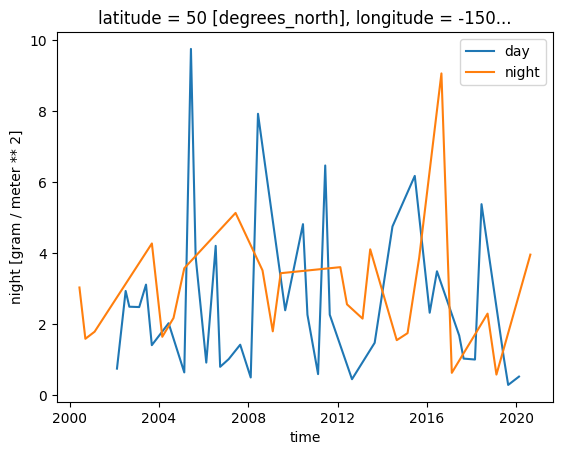

In [17]:
import matplotlib.pyplot as plt
obs_papa.observation.day.dropna("time").plot(label="day")
obs_papa.observation.night.dropna("time").plot(label="night")
plt.legend()
plt.show()

Create structure for SeapoPym simulation.


In [ ]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=data["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1 / 12, timestep=1),
)

## Setup the parameters and the cost function


In [6]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=1,
        night_layer=1,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.05, 0.8),
        # tr_rate=Parameter("D1N1_tr_rate", -1, 0),
        # tr_max=Parameter("D1N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", 0, 0.2),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 500),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=2,
        night_layer=1,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.05, 0.8),
        # tr_rate=Parameter("D2N1_tr_rate", -1, 0),
        # tr_max=Parameter("D2N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", 0, 0.2),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 500),
    ),
]

In [7]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=observations,
)

Set the genetic algorithm meta parameters.


In [8]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.8,
    NGEN=12,
    POP_SIZE=500,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [9]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [10]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

And watch the magic on the Dask dashboard :


In [ ]:
genetic_algo.client

## Run the optimization


In [ ]:
viewer = genetic_algo.optimize()

## Plot the results


In [ ]:
viewer.stats

In [ ]:
viewer.logbook

In [ ]:
viewer.hall_of_fame

In [ ]:
viewer.fitness_evolution()

In [ ]:
viewer.box_plot(3)

In [ ]:
fig = viewer.parallel_coordinates(500, unselected_opacity=0)
fig.update_layout(width=1000, height=700)

# Generate plots at each station


In [19]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from seapopym_optimization import wrapper

In [ ]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {best_individual}")

In [21]:
# best_individual = [
#     [1, 1, 0.15, 1.03800000e01, -0.11, 80, 0.06],
#     [2, 1, 0.18, 1.03800000e01, -0.11, 80, 0.16],
# ]

In [22]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(
        best_individual,
        ["D1N1", "D2N1"],
    ),
)

model_print.run()
biomass_print = model_print.export_biomass()

In [23]:
def plot_comparison_to_station(
    obs_1: pd.Series,
    model_1: pd.Series,
    obs_2: pd.Series,
    model_2: pd.Series,
    station_name: str,
    subplot_titles: tuple = ("D1N1", "D2N1"),
    *,
    obs_as_marker: bool = False,
):
    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=subplot_titles,
        shared_xaxes=True,
        x_title="Time",
        y_title="Biomass (g/m2)",
        vertical_spacing=0.1,
    )

    if obs_as_marker:
        additional_param = {"mode": "markers", "marker": {"symbol": "cross", "size": 4}}
    else:
        additional_param = {"mode": "lines"}

    fig.add_trace(
        go.Scatter(x=obs_1.index, y=obs_1, name=f"Observation {subplot_titles[0]}", **additional_param), row=1, col=1
    )
    fig.add_trace(go.Scatter(x=model_1.index, y=model_1, name=f"Model {subplot_titles[0]}"), row=1, col=1)

    fig.add_trace(
        go.Scatter(x=obs_2.index, y=obs_2, name=f"Observation {subplot_titles[1]}", **additional_param), row=2, col=1
    )
    fig.add_trace(go.Scatter(x=model_2.index, y=model_2, name=f"Model {subplot_titles[1]}"), row=2, col=1)

    fig.update_layout(title=f"{station_name} Station", width=1000, height=700)
    return fig


def clean_series(series):
    return series.pint.quantify().pint.to("g/m2").pint.dequantify().to_series().dropna()

## PAPA


In [ ]:
biomass_papa_plot_day = clean_series(
    biomass_print.sel(latitude=latitude_papa, longitude=longitude_papa, functional_group=0)
)
biomass_papa_plot_night = clean_series(
    biomass_print.sel(latitude=latitude_papa, longitude=longitude_papa).sum("functional_group", keep_attrs=True)
)

obs_papa_plot_day = clean_series(obs_papa.observation.day.isel(latitude=0, longitude=0, layer=0))

obs_papa_plot_night = clean_series(obs_papa.observation.night.pint.quantify().isel(latitude=0, longitude=0, layer=0))


plot_comparison_to_station(
    obs_papa_plot_day, biomass_papa_plot_day, obs_papa_plot_night, biomass_papa_plot_night, "papa", obs_as_marker=True
)

## Taylor diagram


In [ ]:
diagram = ModTaylorDiagram()

all_model = [
    biomass_papa_plot_day,
    biomass_papa_plot_night,
]
all_obs = [
    obs_papa_plot_day,
    obs_papa_plot_night,
]

all_names = ["PAPA DAY", "PAPA NIGHT"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)

diagram.plot()